## Introduction
This is an introduction to implementing reactions in MODFLOW6 with FloPy. This notebook deminstrates both the standard Mobile Storage and Transfer Package [Chapter 3](https://pubs.usgs.gov/tm/06/a61/tm6a61.pdf) and the Immobile Domain Storage and Transfer package [Chapter 7](https://pubs.usgs.gov/tm/06/a61/tm6a61.pdf).

Import the standard libraries

In [1]:
# Import a few libraries
import sys
import os
import time
import copy
import numpy as np
import matplotlib.pyplot as plt
# functions for analytical solutions
from scipy.special import erfc as erfc

# Import the flopy library
import flopy
'flopy' in sys.modules #True

True

First find where you have your MODFLOW6 executables located on your system.

In [2]:
# MODFLOW6 executable (only one)
# Laptop path
exe_path = "C:\\Users\\carla\\Chris\\CH_activities\\win64\\"
# Executable location of Mf6.exe
# Desktop path
# exe_path = "C:\\Hydro\\mf6.4.2\\mf6.4.2_win64\\bin\\"

exe_loc = os.path.dirname(exe_path)
print("Path to MODFLOW 6 executable:", exe_loc)

Path to MODFLOW 6 executable: C:\Users\carla\Chris\CH_activities\win64


Let's use the same directory to save the data as the FloPy introduction and then create a path to this workspace. It may be useful to understand your current working directory, this should be whereever you have this notebook saved. You can double check this with the command 'os.getcwd()'.

In [3]:
# This should return a path to your current working directory
current_directory = os.getcwd()
print(current_directory)

C:\Users\carla\Chris\Dropbox\Teaching\Contaminant hydro 629\Contaminant-Hydrogeology-Activities\MF6_notebooks


If this is not where you want to save stuff then uncomment the cell below and define the path to establish a new folder and set this to be the new working directory.

In [4]:
# # define path
# path = pathlib.Path('C:\\Users\\zahas\\Dropbox\\Teaching\\Contaminant hydro 629\\Notebooks_unpublished')
# # if folder doesn't exist then make it 
# path.mkdir(parents=True, exist_ok=True)
# # set working directory to this new folder
# os.chdir(path)
# current_directory = os.getcwd()
# print(current_directory)

In [5]:
# directory to save data
directory_name = 'reactions_1D_models'
# Let's add that to the path of the current directory
workdir = os.path.join('.', directory_name)

# if the path exists then we will move on, if not then create a folder with the 'directory_name'
if os.path.isdir(workdir) is False:
    os.mkdir(workdir) 
    print("Directory '% s' created" % workdir) 
else:
    print("Directory '% s' already exists" % workdir) 

Directory '.\reactions_1D_models' created


Notice however that we don't yet name the folder where we will save data 'dirname'. This will be an input to our model function.


## 1D Reactions Model Function
The first thing we do is setup the function. We will use nearly identical settings as we used in the [FloPy Introduction notebook](https://github.com/zahasky/Contaminant-Hydrogeology-Activities/blob/master/FloPy%20Introduction.ipynb) example, but now we are providing a few input variables that can be changed everytime we call the model. The input variables are:

### Function Input:
#### directory name
    direname = 

#### period length 
Time is in selected units, the model time length is the sum of this (for steady state flow it can be set to anything). The format for multi-period input: ```[60., 15*60]```
 
    perlen = 

#### Porosity

    prsity = 
    
#### advection velocity
Note that this is only an approximate advection flow rate in due to the way that the inlet boundary conditions are being assigned in the MODFLOW BAS6 - Basic Package. More rigorous constraint of constant flux boundaries require the Flow and Head Boundary Package, the Well Package, or the Recharge Package.

    v = 
    
#### dispersivity
Set the longitudinal dispersivity in selected units. What are the units again?

    al = 
    
### Reaction model input  
#### Model type
sorbtion (boolean) is a text keyword to indicate that sorbtion will be activated. Use of this keyword requires that BULK_DENSITY and DISTCOEF are specified. Options for input include 'linear', 'Freundlich' and 'Langmuir'

    sorption = 

#### bulk density ($\rho_b$)
This can be a float or array of floats (nlay, nrow, ncol). rhob is the bulk density of the aquifer medium (unit, ML-3).

#### First sorption parameter (distcoef)
Can be a float or array of floats (nlay, nrow, ncol). The use of distcoef depends on the type of sorption selected.

For linear sorption distcoef is the distribution coefficient (Kd) (unit, L3M-1). 

For Freundlich sorption distcoef is the Freundlich equilibrium constant (Kf) (the unit depends on the Freundlich exponent a). 

For Langmuir sorption distcoef is the Langmuir equilibrium constant (Kl) (unit, L3M-1 ). 

For example 
    
    sorption = 'linear'
    distcoef = kd 

Where 
    
    kd = (retardation - 1.) * prsity / rhob

#### Second sorption parameter (sp2)
sp2 can be a float or array of floats (nlay, nrow, ncol). The use of sp2 depends on the type of sorption model selected. 

For linear sorption sp2 is read but not used. 

For Freundlich sorption sp2 is the Freundlich exponent N. 

For Langmuir sorption sp2 is the total concentration of the sorption sites available ( S ) (unit, MM-1). 

For example 
    
    sorption = 'freundlich'
    distcoef = kf
    sp2 = N


#### Additional Reaction Package input options for first and zero order reactions 
`first_order_decay` is a flag indicating the use of first-order kinetic reactions. `zero_order_decay` is flag indicating the use of zero-order kinetic reactions. This needs to be added to the mst package following the [Flopy documentation](https://flopy.readthedocs.io/en/3.3.2/source/flopy.mf6.modflow.mfgwtmst.html). Note that either of these also requires the keywords `DECAY` and `DECAY_SORBED` to be defined.

In [6]:
def reaction_model_1D(dirname, perlen, v, al, prsity, 
                      sorption = 'linear', bulk_density = 1.5, distcoef = 0, sp2=0, 
                      first_order_decay = True, decay = 0, decay_sorbed = 0,
                      Cinj=1.0, mixelm=-1, C0=0):
    # start timer to measure how fast the model runs
    tic = time.perf_counter()
    # Model workspace and new sub-directory
    model_ws = os.path.join(workdir, dirname)
    print(model_ws)

    gwfname = 'gwf-' + dirname
     # create the MF6 simulation
    sim = flopy.mf6.MFSimulation(sim_name=dirname, exe_name=os.path.join(exe_loc, 'mf6.exe'), sim_ws=model_ws, 
                                verbosity_level = 2)
    
    # time and length units - use lab units for now
    length_units = "CENTIMETERS"
    time_units = "MINUTES"

    # Modflow stress periods
    # number of stress periods (MF input), calculated from period length input
    nper = len(perlen)
    # nstp (integer) is the number of time steps in a stress period.
    # tsmult (double) is the multiplier for the length of successive time steps. 
    tsmult = 1
    tdis_rc = []
    # loop through perlen and assign period lengths
    for i in range(nper):
        tdis_rc.append((perlen[i], perlen[i]*6, tsmult))
    flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_rc, time_units=time_units)

    # Instantiating MODFLOW 6 groundwater flow model
    gwf = flopy.mf6.ModflowGwf(sim, modelname=gwfname, save_flows=True, 
            model_nam_file=f"{gwfname}.nam") 

    # Instantiating MODFLOW 6 solver for flow model
    imsgwf = flopy.mf6.ModflowIms(sim, complexity = "SIMPLE")
    sim.register_ims_package(imsgwf, [gwf.name])
    
    # Model information 
    nlay = 1 # number of layers
    nrow = 1 # number of rows
    ncol = 101 # number of columns
    top = 0 # grid size in direction of Lz
    delc = 4.4 # grid size in direction of Ly, this was choosen such that the model has the same cross-sectional area as the column from the dispersion notebook example
    delr = 0.1 # grid size in direction of Lx
    botm  = -4.4
    
    # length of model in selected units 
    Lx = (ncol - 1) * delr
    print("Model length is: " + str(Lx + delr) + ' ' + str(length_units))

    # Instantiating MODFLOW 6 discretization package
    flopy.mf6.ModflowGwfdis(gwf, length_units=length_units,
            nlay=nlay, nrow=nrow, ncol=ncol, delr=delr, delc=delc,
            top=top, botm=botm,
            filename=f"{gwfname}.dis")
    
    # hydraulic conductivity
    HK = 1. # what are the units here?
    
    # Instantiating MODFLOW 6 node-property flow package
    flopy.mf6.ModflowGwfnpf(gwf, save_flows=False, icelltype=0,
            k=HK) # k is the hydraulic conductivity 

    # Instantiating MODFLOW 6 initial conditions package for flow model
    # gwf_strt = np.zeros((nlay, nrow, ncol), dtype=float)
    flopy.mf6.ModflowGwfic(gwf, strt=0.0)
        
    # discharge is based on advection velocity input (again in selected units)
    q = v * prsity 
    print("Discharge = " + str(q))
    
    h1 = q * Lx / HK
    print("calculated head differential across column based on provided advection velocity = " + str(h1) )

    # Constant head cells are specified on both ends of the model
    chdspd = [[(0, 0, 0), h1], [(0, 0, ncol - 1), 0.0]]
    # Instantiating MODFLOW 6 constant head package
    flopy.mf6.ModflowGwfchd(gwf, maxbound=len(chdspd), 
                            stress_period_data=chdspd,
                            save_flows=False, pname="CHD1")
    
    # FLow output control
    flopy.mf6.ModflowGwfoc(gwf,
        head_filerecord=f"{gwfname}.hds",
        saverecord=[("HEAD", "ALL")],
        printrecord=[("HEAD", "FIRST"), ("HEAD", "LAST"),])

    #############################################################
    ############### NOW BUILD TRANSPORT #########################
    print(f"Building mf6gwt model in...{model_ws}")
    gwtname = "gwt_" + dirname
    gwt = flopy.mf6.MFModel(sim,
            model_type="gwt6", modelname=gwtname,
            model_nam_file=f"{gwtname}.nam")
    # gwt.name_file.save_flows = True

    # create iterative model solution and register the gwt model with it
    imsgwt = flopy.mf6.ModflowIms(sim, print_option="SUMMARY", linear_acceleration="BICGSTAB",
            filename=f"{gwtname}.ims")
    sim.register_ims_package(imsgwt, [gwt.name])

    # Instantiating MODFLOW 6 transport discretization package
    flopy.mf6.ModflowGwtdis(gwt, nlay=nlay, nrow=nrow, ncol=ncol,
            delr=delr, delc=delc, top=top, botm=botm,
            filename=f"{gwtname}.dis")

    # Initial conditions
    # initial concentration set to zero everywhere
    # Instantiating MODFLOW 6 transport initial concentrations
    flopy.mf6.ModflowGwtic(gwt, strt=C0, filename=f"{gwtname}.ic")

    # Solute boundary conditions
    # cncspd = [[(0, 0, 0), Cinj]] # constant
    cncspd = {0: [[(0, 0, 0), Cinj]], 1: [[(0, 0, 0), 0]]} # pulse
    # Instantiating MODFLOW 6 transport constant concentration package
    flopy.mf6.ModflowGwtcnc(gwt, maxbound=len(cncspd), stress_period_data=cncspd)

    flopy.mf6.ModflowGwtssm(gwt)
    
    # Mobile Storage and Transfer (MST) Package of the GWT Model for MODFLOW 6 represents solute mass storage, sorption, and frst- or zero-order decay in MOBILE domain.
    # flopy.mf6.ModflowGwtmst(gwt, porosity=prsity) # without reactions
    # With reactions
    flopy.mf6.ModflowGwtmst(gwt, sorption=sorption, porosity = prsity, 
            bulk_density = bulk_density, distcoef = distcoef, sp2=sp2,
            first_order_decay =first_order_decay, decay=decay, decay_sorbed=decay_sorbed,
            filename=f"{gwtname}.mst")

    # Instantiating MODFLOW 6 transport advection package
    if mixelm == 1:
        scheme = "UPSTREAM"
    elif mixelm == -1:
        scheme = "TVD"
    elif mixelm == 2:
        scheme = "CENTRAL"
    else:
        raise Exception()
    flopy.mf6.ModflowGwtadv(gwt, scheme=scheme)

    # define dispersion/diffusion behavior
    flopy.mf6.ModflowGwtdsp(gwt, xt3d_off=True, alh=al, ath1=al)

    # Instantiating MODFLOW 6 transport output control package
    flopy.mf6.ModflowGwtoc(gwt,
            budget_filerecord=f"{gwtname}.cbc",
            concentration_filerecord=f"{gwtname}.ucn",
            # concentrationprintrecord=[("COLUMNS", 10, "WIDTH", 15, "DIGITS", 6, "GENERAL")],
            saverecord=[("CONCENTRATION", "ALL"), ("BUDGET", "ALL")],
            printrecord=[("CONCENTRATION", "ALL"), ("BUDGET", "ALL")])

    # Instantiating MODFLOW 6 flow-transport exchange mechanism
    flopy.mf6.ModflowGwfgwt(sim,
            exgtype="GWF6-GWT6",
            exgmnamea=gwfname, exgmnameb=gwtname,
            filename=f"{dirname}.gwfgwt")

    # Write simulation
    sim.write_simulation(silent=True)
    success, buff = sim.run_simulation(silent=True)

    # Extract head and concentration field data
    head = gwf.output.head().get_data()
    conc = gwt.output.concentration().get_alldata() # get_data() retrieves only the last timestep
    # extract time array
    times = np.array(gwt.output.concentration().get_times())
    
    # Time the function
    toc = time.perf_counter()
    print("Model " + dirname + " ran in " + str(toc-tic) + " seconds")
    print('.')
    
    return conc, head, times

Now lets trying running a model by calling our 'model_1D' function

In [7]:
dirname = 'run1'
perlen = [120] # min

v = 0.40# cm/min
al = 0.25 # cm
Cinj = 1.0
prsity = 0.2
distcoef = 0.2
bulk_density = 1.5

# Call the FloPy model function
conc_conserv, head, times = reaction_model_1D(dirname, perlen, v, al, prsity, sorption = 'linear', bulk_density = bulk_density, distcoef = 0)
conc_retard, head, times = reaction_model_1D(dirname, perlen, v, al, prsity, sorption = 'linear', bulk_density = bulk_density, distcoef = distcoef)


.\reactions_1D_models\run1
Model length is: 10.1 CENTIMETERS
Discharge = 0.08000000000000002
calculated head differential across column based on provided advection velocity = 0.8000000000000002
Building mf6gwt model in....\reactions_1D_models\run1
Model run1 ran in 1.1940076 seconds
.
.\reactions_1D_models\run1
Model length is: 10.1 CENTIMETERS
Discharge = 0.08000000000000002
calculated head differential across column based on provided advection velocity = 0.8000000000000002
Building mf6gwt model in....\reactions_1D_models\run1
Model run1 ran in 0.9111911999999993 seconds
.


Now let's plot the model output as a function of time

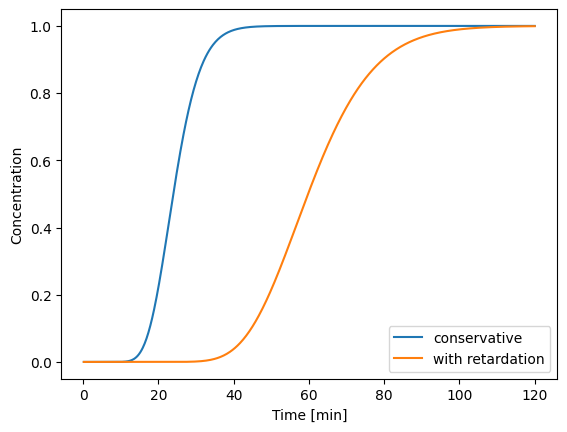

In [8]:
# extract the concentration at the outlet of the model
c_btc = conc_conserv[:, 0, 0, -1]
c_btc_r = conc_retard[:, 0, 0, -1]
# now plot the time vs the concentration at the outlet
plt.plot(times, c_btc, label = 'conservative')
plt.plot(times, c_btc_r, label = 'with retardation')
plt.xlabel('Time [min]')
plt.ylabel('Concentration')
plt.legend()
plt.show()

What type of sorption is this (Hint: look at the model input)? Given the model input, what is the retardation coefficient?

### Now let's combined retardation and first order reactions

In [9]:
dirname = 'run2'
mu = 0.01
# Now run the model using the same retardation parameters as above
conc_r_1st, head, times = reaction_model_1D(dirname, perlen, v, al, prsity, 
                      sorption = 'linear', bulk_density = bulk_density, distcoef = distcoef, sp2=0, 
                      first_order_decay = True, decay = mu, decay_sorbed = mu,
                      Cinj=1.0, mixelm=1, C0=0)


.\reactions_1D_models\run2
Model length is: 10.1 CENTIMETERS
Discharge = 0.08000000000000002
calculated head differential across column based on provided advection velocity = 0.8000000000000002
Building mf6gwt model in....\reactions_1D_models\run2
Model run2 ran in 1.0433807999999996 seconds
.


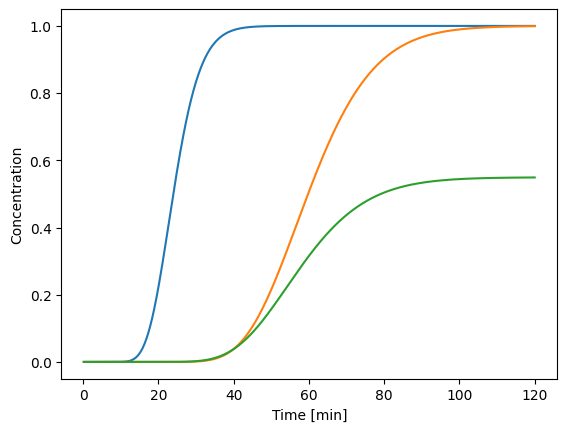

In [10]:
# extract the concentration at the outlet of the model
c_btc_r_1st = conc_r_1st[:, 0, 0, -1]
# now plot the time vs the concentration at the outlet
plt.plot(times, c_btc, label = 'conservative')
plt.plot(times, c_btc_r, label = 'with retardation')
plt.plot(times, c_btc_r_1st, label = 'with retardation and 1st order term')
plt.xlabel('Time [min]')
plt.ylabel('Concentration')
# plt.legend()
plt.show()

Can you identify which lines belong to which model? To check your answer uncomment the line containing the command `plt.legend()` and re-run the cell.

## 1D Analytical Solution Function
Now lets compare the numerical results with the analytical solution we looked at in our previous notebook [First Order Reactions](https://github.com/zahasky/Contaminant-Hydrogeology-Activities/blob/master/First%20Order%20Reactions.ipynb).

In [11]:
# Retardation with 1st type BC (equation C5)
# 'u' term identical in equation c5 and c6 (type 3 inlet)
# Write out the name of each of these variables
def ADEwReactions_type1_fun(x, t, v, D, R, gamma, mu, C0, t0, Ci):
    u = v*(1+(4*mu*D/v**2))**(1/2)
    
    # Note that the '\' means continued on the next line
    Atrf = np.exp(-mu*t/R)*(1- (1/2)* \
        erfc((R*x - v*t)/(2*(D*R*t)**(1/2))) - \
        (1/2)*np.exp(v*x/D)*erfc((R*x + v*t)/(2*(D*R*t)**(1/2))))
    
    # term with B(x, t)
    Btrf = 1/2*np.exp((v-u)*x/(2*D))* \
        erfc((R*x - u*t)/(2*(D*R*t)**(1/2))) \
        + 1/2*np.exp((v+u)*x/(2*D))* erfc((R*x + u*t)/ \
        (2*(D*R*t)**(1/2)))
    
    # if a pulse type injection
    if t0 > 0:
        tt0 = t - t0
        
        indices_below_zero = tt0 <= 0
        # set values equal to 1 (but this could be anything)
        tt0[indices_below_zero] = 1
    
        Bttrf = 1/2*np.exp((v-u)*x/(2*D))* \
            erfc((R*x - u*tt0)/(2*(D*R*tt0)**(1/2))) \
            + 1/2*np.exp((v+u)*x/(2*D))* erfc((R*x + u*tt0)/ \
            (2*(D*R*tt0)**(1/2)))
        
        # Now set concentration at those negative times equal to 0
        Bttrf[indices_below_zero] = 0
        if mu >0:
            C_out = (gamma/mu)+ (Ci- gamma/mu)*Atrf + \
                (C0 - gamma/mu)*Btrf - C0*Bttrf
        else:
            C_out = Ci*Atrf + C0 *Btrf - C0*Bttrf
            
    else: # if a continous injection then ignore the Bttrf term (no superposition)
        if mu >0:
            C_out = (gamma/mu)+ (Ci- gamma/mu)*Atrf + (C0 - gamma/mu)*Btrf;
        else: # if mu = 0 then we would get nans
            C_out = (Ci)*Atrf + (C0)*Btrf
        
    
    # Return the concentration (C) from this function
    return C_out

Call the function to calculate the breakthrough curve at outlet of the core

In [12]:
# Column length (cm)
x = 10.0 # see model output
# Dispersion
D = v*al
print('Dispersivity: ' + str(D))
print(v)
t0 = 0 # remember this means that it is a continous injection
C0 = 0 # initial concentration is zero

# general first-order decay constant 
mu_combined = mu + mu*bulk_density*distcoef/prsity

# Sorption parameter calculation
# retardation factor (R)
R = 1 + bulk_density*distcoef/prsity
print('Retardation factor: ' +str(R))
# define the zero order term
gamma = 0

Dispersivity: 0.1
0.4
Retardation factor: 2.5


What are the units of these two parameters?

In [13]:
# Call the analytical model function
analytical_r_1st = ADEwReactions_type1_fun(x, times, v, D, R, gamma, mu_combined, Cinj, t0, C0)

Now let's plot a comparison.

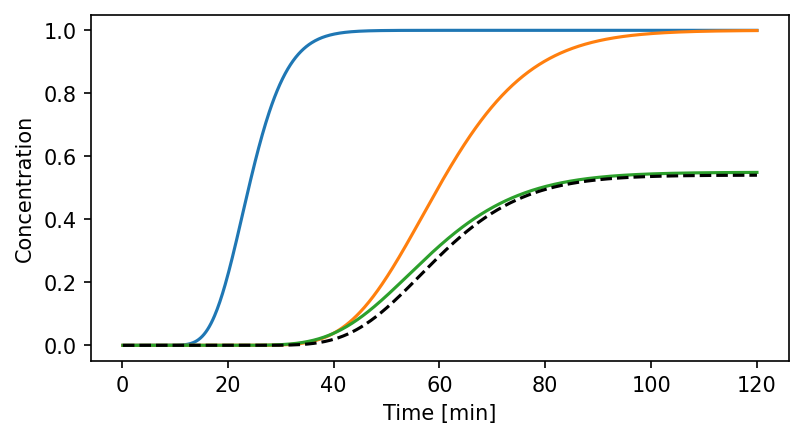

In [14]:
plt.figure(figsize=(6, 3), dpi=150)

plt.plot(times, c_btc, label = 'conservative')
plt.plot(times, c_btc_r, label = 'with retardation')
plt.plot(times, c_btc_r_1st, label = 'numerical with retardation and 1st order term')
plt.plot(times, analytical_r_1st, 'k--', label='analytical with retardation and 1st order term')

plt.xlabel('Time [min]')
plt.ylabel('Concentration')
# plt.legend()
plt.show()

Explain why the analytical solution (dashed black line) most closely matches the green line.

## Activity:
Using these codes, evaluate the concentration profile along the column at a few different times and under different reaction conditions.

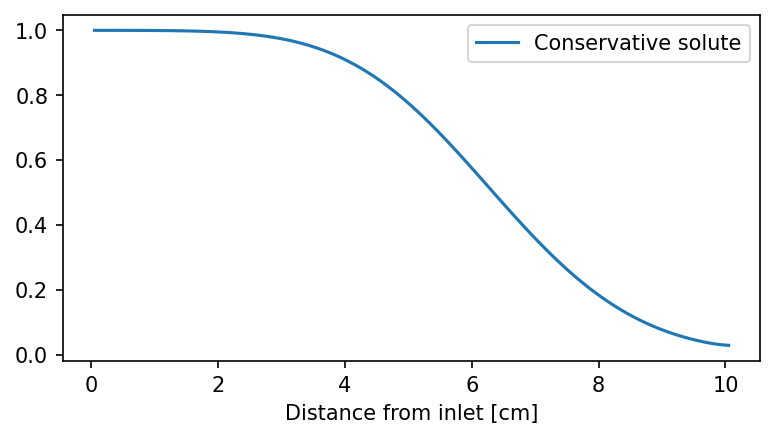

In [22]:
x = np.linspace(0.05, 10.05, 101)
# Extract the concetration profile at a specific timestep
plt.figure(figsize=(6, 3), dpi=150)
plt.plot(x, conc_conserv[90, 0, 0, :], label='Conservative solute')

plt.xlabel('Distance from inlet [cm]')
plt.legend()
plt.show()

#### Work through the following questions:
Explain the differences between concentration profiles when different sorption models are used at timestep = 90. 

Is the max concentration the same at equivalent points in time? 

How do first-order reactions impact the concentration profile relative to the conservative solutes?